In [ ]:
import sys

sys.path.append('../scripts')

In [4]:


from tqdm.notebook import tqdm
from scripts import graph_osm_loader

import networkx as nx

Примеры как резолвить комьюнити

In [79]:
GRAPH_ID = 'R13470549'  # R13470549 R2555133 R3766483

In [93]:
# примеры id есть в graph_osm_loader.py
g = graph_osm_loader.get_graph(GRAPH_ID)  # загрузка графа
len(g.nodes), len(g.edges)

(715, 1038)

In [84]:
g.remove_edges_from(nx.selfloop_edges(g))

In [8]:
name = 'cluster'

In [63]:

import networkx as nx


def bi_dijkstra_pfa(graph: nx.Graph,
                    start: int,
                    end: int,
                    cutoff = 1e6
                    ) -> tuple[float, list[int]]:
    adjacency = graph._adj
    push = heappush
    pop = heappop
    dist = (set(), set())
    fringe = ([], [])
    c = count()

    push(fringe[0], (0, next(c), 0, start))
    push(fringe[1], (0, next(c), 0, end))

    heads = [0, 0]
    seens = ({start: (0, None, 0)}, {end: (0, None, 0)})
    union_node = None
    union_dst = float('inf')
    dir = 1
    while fringe[0] or fringe[1]:
        if fringe[0] and fringe[1]:
            dir = 1 - dir
        elif fringe[0]:
            dir = 0
        else:
            dir = 1

        (d, _, n, v) = pop(fringe[dir])

        heads[dir] = d

        if v in dist[dir]:
            continue

        dist[dir].add(v)
        if v in dist[1-dir]:
            break
        for u, l in adjacency[v].items():
            if u in {start, end}:
                continue
            
            vu_dist = d + 1
            if u not in dist[dir] and (u not in seens[dir] or seens[dir][u][0] > vu_dist):
                seens[dir][u] = (vu_dist, v, n + 1)
                push(fringe[dir], (vu_dist, next(c), n + 1, u))
                if u in seens[1 - dir]:
                    tpl = seens[1 - dir][u]
                    dd = tpl[0] + vu_dist
                    if dd < union_dst:
                        union_dst = dd
                        union_node = u
        if sum(heads) > cutoff:
            break
    if sum(heads) > cutoff:
        return None
    path = []
    e = union_node
    while seens[0][e][1] is not None:
        e1 = seens[0][e][1]
        path = [e] + path
        e = e1
    e = union_node
    while seens[1][e][1] is not None:
        e1 = seens[1][e][1]
        path += [e1]
        e = e1
    path += [end]
    return union_dst, path


In [48]:
g.edges

EdgeView([(27717690, 3067941815), (28041755, 2393697879), (28041755, 59638521), (28041755, 59638524), (28041755, 36801227), (28043165, 60661112), (28043165, 48837085), (28043165, 3728937844), (28043165, 86666643), (28043605, 4055255647), (28043605, 446842600), (28043605, 4055255643), (31404640, 1273327638), (31404640, 31449090), (31404640, 255419198), (31404670, 81382212), (31404670, 38441249), (31404670, 148620201), (31445671, 169123177), (31445671, 31445672), (31445671, 178158296), (31445672, 267307202), (31445672, 1699170560), (31445678, 268948060), (31445678, 264445074), (31445678, 597387201), (31445679, 264445074), (31445679, 264445077), (31445679, 644014435), (31445680, 264445099), (31445680, 80260467), (31445680, 338867742), (31446487, 255408043), (31446487, 248950229), (31446487, 251615062), (31446488, 251615062), (31446488, 251615061), (31446488, 488147184), (31446489, 488147184), (31446489, 254462067), (31446489, 983139925), (31447277, 96938359), (31447277, 304335420), (31447

AtlasView({268903413: {'length': 33.931}, 5115471161: {'length': 15.394}, 11981418212: {'length': 27.529}})

In [52]:
p1,p2 = 11981418211, 11981418212
p2 in g[p1]

True

In [94]:
def get_4(g:nx.Graph,u1,u2):
    n1,n2 = set(g[u1].keys()), set(g[u2].keys())
    l = []
    for u in n1:
        if u in {u1,u2}:
            continue
        for v in n2:
            if v in {u1,u2}:
                continue
            if u == v :
                continue
            if (u,v) in g.edges():
                q = [u1,u,v,u2]
                l.append(q)
    return l
def get_3(g,u1,u2):
    n1,n2 = set(g[u1].keys()), set(g[u2].keys())
    nn = n1.intersection(n2)
    if len(nn) == 0:
        return []
    else:
        l = []
        for u in nn:
            q = [u,u1,u2]
            q.sort()
            l.append(q)
        return l
e = set()
c = set()
for u,v in g.edges():
    for l in get_4(g,u,v):
        p1,p2,p3,p4 = l
        L = g.edges()[p1,p2]['length'] + g.edges()[p2,p3]['length'] + g.edges()[p3,p4]['length']+ g.edges()[p4,p1]['length'] 
        q = [p1,p2,p3,p4]
        q.sort()
        q = tuple(q)
        if L < 500 and q not in c:
            c.add(q)
            e.add((p1,p3))
for p1,p2 in e:
    g.add_edge(p1,p2,length = nx.single_source_dijkstra(g,p1,p2,weight='length')[0])

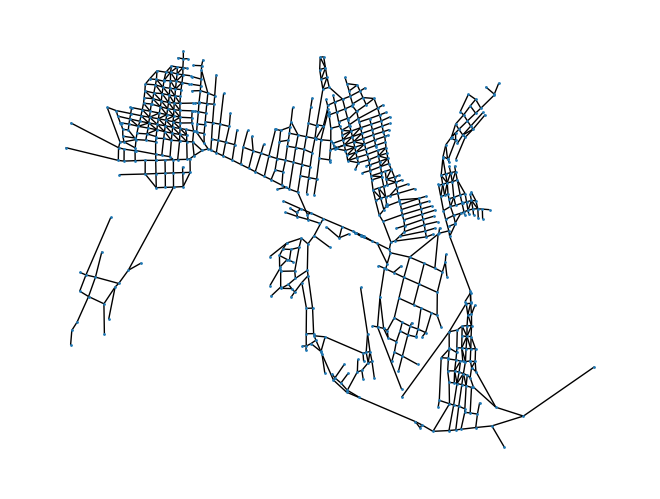

In [95]:
from matplotlib import pyplot as plt
pos = {u:[d['x'],d['y']] for u,d in g.nodes(data=True)}
# cmsp = plt.get_cmap('brg')
# node_color = [cmsp(d['dst']/M) for _,d in g.nodes(data=True)]
nx.draw(g, pos=pos,  node_size=1)

In [67]:
bi_dijkstra_pfa(g,11981418211, 11981418212, cutoff=2)

In [13]:
from heapq import heappop, heappush
from itertools import count
import networkx as nx


def dijkstra_k_n(graph: nx.Graph,
                 start: int,
                 k = 10) -> \
        dict[int, float]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []
    push(fringe, (0.0, next(c), 0, start, None))
    while fringe:
        (d, _, n, v, p) = pop(fringe)
        if v in dist:
            continue
        dist[v] = d
        if len(dist) == k+1:
            break
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist:
                push(fringe, (vu_dist, next(c), n + 1, u, v))
    return dist

In [14]:
g.nodes()

NodeView((27717690, 28041755, 28043165, 28043605, 31404640, 31404670, 31445671, 31445672, 31445678, 31445679, 31445680, 31446487, 31446488, 31446489, 31447277, 31447354, 31447629, 31448037, 31448039, 31448214, 31448417, 31449054, 31449066, 31449090, 31449096, 31449188, 31449212, 31449281, 31449514, 33533760, 33583684, 35625925, 35625931, 35880127, 35881070, 35881796, 35881998, 35883712, 35883714, 35884663, 35885285, 35885297, 35898204, 35898206, 35898216, 35898438, 35898449, 35900116, 35900118, 35901575, 35903409, 35904769, 35904913, 35905114, 35905125, 35907778, 35907784, 35908449, 35908453, 35911438, 35911439, 35911653, 35912046, 35912569, 35921172, 35925240, 35925258, 35925412, 35925425, 35925624, 35925742, 35925896, 35925923, 35926256, 35926379, 35969501, 35969506, 35969515, 35969668, 35969742, 35969967, 35970090, 35970177, 35970178, 36157582, 36157597, 36157720, 36158010, 36158017, 36158421, 36158522, 36158895, 36159957, 36160085, 36160479, 36160614, 36160942, 36160957, 36162019, 

  0%|          | 0/715 [00:00<?, ?it/s]

(array([ 1.,  2.,  3.,  3.,  0.,  6.,  4.,  6.,  6.,  5., 14.,  9., 11.,
        16., 16., 16., 12., 11., 15., 14., 10., 17., 14., 22., 11., 12.,
         3., 13.,  4., 15.,  7., 11., 10.,  5., 12.,  9.,  6., 10., 12.,
        11.,  9.,  7., 10.,  9.,  8.,  6., 10., 10., 12.,  8., 11.,  6.,
        15., 10., 10., 11., 12., 16., 14., 12., 14., 16., 16., 13., 16.,
         8.,  6.,  2.,  5.,  2.,  2.,  0.,  1.,  1.,  1.,  2.,  1.,  1.,
         2.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  1.,  1.,  2.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  3.]),
 array([ 7071.96   ,  7141.06855,  7210.1771 ,  7279.28565,  7348.3942 ,
         7417.50275,  7486.6113 ,  7555.71985,  7624.8284 ,  7693.93695,
         7763.0455 ,  7832.15405,  7901.2626 ,  7970.37115,  8039.4797 ,
         8108.58825,  8177.6968 ,  8246.80535,  8315.9139 ,  8385.02245,
         8454.131  ,  8523.23955,  8592.3481 ,  8661.45665,  8730.5652 ,
         8799.67375,  8868.7823 ,  8937.89085,  9006.9994 ,  9076.107

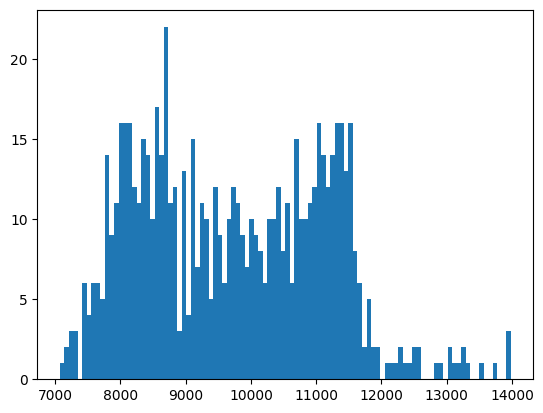

In [86]:
k = 1000
for u,d in tqdm(g.nodes(data=True)):
    l = max(dijkstra_k_n(g, u,k).values())
    d['dst'] = l
x = [d['dst'] for _,d in g.nodes(data=True)]
plt.hist(x,bins=100)

In [37]:
M = max([d['dst'] for _,d in g.nodes(data=True)])
M, min([d['dst'] for _,d in g.nodes(    data=True)])

(3284.6259999999984, 7.379)

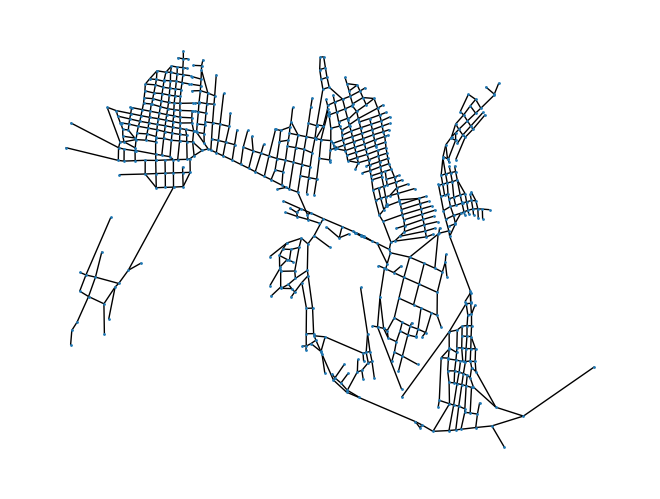

(array([1.652e+03, 3.069e+03, 2.028e+03, 1.767e+03, 1.569e+03, 1.457e+03,
        1.125e+03, 8.930e+02, 7.830e+02, 5.790e+02, 5.160e+02, 3.980e+02,
        3.730e+02, 2.550e+02, 2.370e+02, 1.540e+02, 1.500e+02, 1.220e+02,
        8.700e+01, 1.100e+02, 9.400e+01, 7.200e+01, 5.700e+01, 5.200e+01,
        3.300e+01, 3.100e+01, 3.200e+01, 2.700e+01, 2.100e+01, 2.200e+01,
        1.600e+01, 1.200e+01, 1.400e+01, 6.000e+00, 1.400e+01, 1.300e+01,
        7.000e+00, 1.000e+01, 6.000e+00, 7.000e+00, 5.000e+00, 5.000e+00,
        3.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 0.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

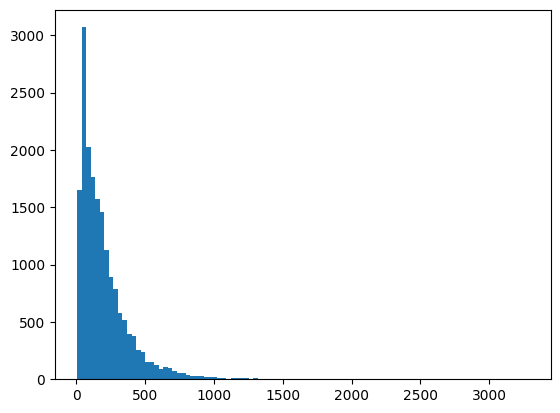

In [16]:
len(g.nodes), len(g.edges), nx.density(g)

(17923, 27016, 0.00016821079582192427)

In [ ]:
err_mean: 2.0645210633146847
err_min: 0.00
err_max: 13.884030723713758
28.657796478018895

In [151]:
err_mean: 2.8923300632128575
err_min: -0.00
err_max: 32.62733053488925
33.35979368025584

(12817.261,
 [597205291,
  597205297,
  597205309,
  255866026,
  268944231,
  308040240,
  1401862769,
  310836425,
  2701185869,
  311965578,
  268943919,
  442566951,
  258079342,
  314594688,
  893925294,
  268269543,
  2869262608,
  268182820,
  1105820566,
  1105820548,
  1105820578,
  260238216,
  10785371161,
  198636662,
  266722907,
  1462520565,
  44476643,
  44471836,
  44467031,
  44461396,
  44491058,
  3802868348,
  44386458,
  44376902,
  44376902,
  44384577,
  44381531,
  44372134,
  43228220,
  43227235,
  248611621,
  248611617,
  4404039711,
  11802142361,
  267608081,
  248610804,
  985173831,
  248610805,
  43079203,
  35901575,
  293194731,
  293189479,
  3652576176,
  2447031733,
  3792445501,
  2442536904,
  36419278,
  1856760330,
  3792445551,
  293194994,
  2376985967,
  319834414,
  7907809162])